TODO:


1.   m1 vs m0/sqrt(alpha') a vari d e confrontando con 1/sqrt(1+x^2)



# Libraries and Functions

In [7]:
import numpy as np
from scipy.special import iv  # iv(ν, x) = I_ν(x) (modified Bessel function of first kind)
import scipy as sp
from scipy.integrate import quad
from scipy.optimize import bisect
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')
data_PATH = "gdrive/MyDrive/Associative_memory/vectorial_hopfield/notebooks_first_step/graphs_savings/"


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
def K_d(d, x):
    r"""
    Implements  K_d(x) = (2π)^(d/2) * I_{d/2 - 1}(x) / x^(d/2 - 1).
    """
    # Avoid x=0 to prevent division by zero.  In many contexts x>0 anyway.
    if x == 0:
        # If needed, handle a limiting value or raise an error.
        return 0.0
    # Compute the factor out front: (2π)^(d/2)
    factor = (2.0 * np.pi)**(0.5 * d)
    # Compute the Bessel ratio
    return factor * iv(0.5*d - 1, x) / (x**(0.5*d - 1))

def g_d(d, x):
    r"""
    Implements  g_d(x) = I_{d/2}(x) / I_{d/2 - 1}(x).
    """
    # Again, watch out for x=0.  If x>0 in your problem, it is simpler.
    if x == 0:
        # If needed, handle or raise an error
        return 0.0
    return iv(0.5*d, x) / iv(0.5*d - 1, x)


In [3]:
def compute_m1(m0, alpha, d, sup=np.inf):
    """
    Numerically computes m1 for given m0, alpha, and d,
    by integrating from 0 to infinity using scipy.integrate.quad.
    """

    def integrand(u):
        # Factor in front
        prefactor = u**(d -1) / ( (2.0 * np.pi)**(d / 2.0) )

        # The exponential part
        exponent = -0.5 * (u*u)  -  0.5 * (m0*m0)*d*d / alpha

        # Argument for the special functions
        arg = m0 * u * np.sqrt(d)  / np.sqrt(alpha/d)

        return prefactor * np.exp(exponent) * K_d(d, arg) * g_d(d, arg)

    def integral_d1(u):
        erf = sp.special.erf(u/(np.sqrt(2)))
        return erf

    if d == 1:
        val = integral_d1(m0/np.sqrt(2*alpha))
        return val
    else:
        val, _ = quad(integrand, 0, sup)
    return val

def compute_m1_array(m0_values, alpha, d, sup=np.inf):
    """
    Given an array (or list) of m0 values, returns a NumPy array
    of corresponding m1 values.
    """
    return np.array([compute_m1(m0, alpha, d, sup) for m0 in m0_values])

In [4]:
from scipy.optimize import root_scalar
from scipy.optimize import fsolve

def find_fixed_point(d, alpha, x0=0.5, method='bisect', bracket=(0.01, 0.99)):
    def func(m0):
        return compute_m1(m0, alpha, d, sup=30) - m0

    # Example using brentq (you can also try 'secant' or 'newton' if you provide a derivative)
    sol = root_scalar(func, bracket=bracket, method=method)
    return sol.root

def find_fixed_points_for_alphas(d, alpha_values, bracket=(0.01, 0.99)):
    """
    Given a list/array of alpha values, return the list of fixed points
    m0 for each alpha, using find_fixed_point.
    """
    return np.array([find_fixed_point(d, alpha, bracket) for alpha in alpha_values])

# Results

In [5]:
from re import X
x_arr = np.arange(0.001, 10, 0.1)
d_arr = np.array([32,16,8,4,2,1])

x_results = np.zeros((len(d_arr), len(x_arr)), dtype=np.float64)

for i, d in enumerate(d_arr):
    x_results[i] = compute_m1_array(x_arr, d, d, sup=30)

/tmp/ipython-input-3461893441.py:12: RuntimeWarning: overflow encountered in scalar multiply
  return factor * iv(0.5*d - 1, x) / (x**(0.5*d - 1))
/tmp/ipython-input-3461893441.py:22: RuntimeWarning: invalid value encountered in scalar divide
  return iv(0.5*d, x) / iv(0.5*d - 1, x)
/tmp/ipython-input-2140813937.py:17: RuntimeWarning: invalid value encountered in scalar multiply
  return prefactor * np.exp(exponent) * K_d(d, arg) * g_d(d, arg)
/tmp/ipython-input-2140813937.py:27: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, _ = quad(integrand, 0, sup)
/tmp/ipython-input-2140813937.py:27: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singula

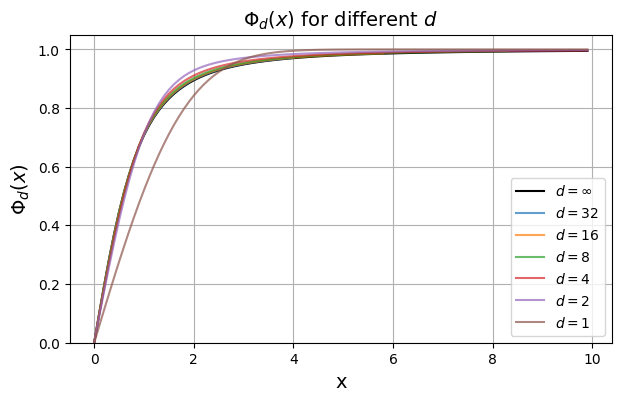

In [6]:
plt.figure(figsize=(7,4))

plt.plot(x_arr, x_arr/np.sqrt(1+x_arr**2), color="black", label=r"$d=\infty$")
for i, d in enumerate(d_arr):
    plt.plot(x_arr, x_results[i], label=r"$d={}$".format(d), alpha=0.7)

plt.ylim((0,1.05))
plt.xlabel("x", fontsize=14)
plt.ylabel(r"$\Phi_d(x)$", fontsize=14)
plt.title(r"$\Phi_d(x)$ for different $d$", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [9]:
# Array of m0 values
m0_array = np.arange(0.00001, 0.99999, 0.02, dtype=np.float64)

d_arr = np.array([16,8,4,2])

m1_results = np.zeros((len(d_arr), len(m0_array)), dtype=np.float64)

alpha_val = 0.5

for i, d in enumerate(d_arr):
    #alpha_prime = alpha_val*d
    m1_results[i] = compute_m1_array(m0_array, alpha_val, d, sup=29)

In [8]:
name_save = "retrieval_maps_N500_P250.npy"
basins = np.load(data_PATH+name_save)

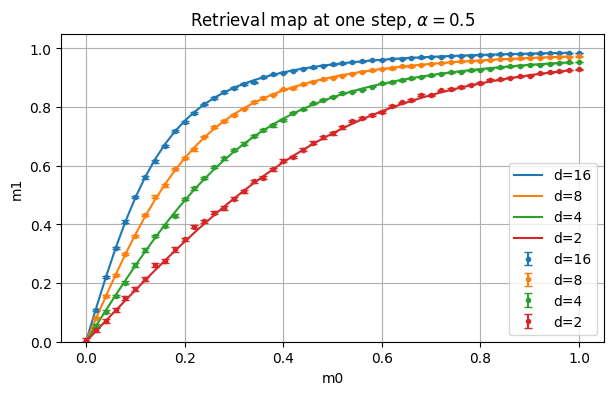

In [11]:
plt.figure(figsize=(7,4))

num_of_run=20
init_overlaps_array = np.arange(0,1.01,0.02)
N=500
P=250

colors = ["C0", "C1", "C2", "C3", "C4"]

for i, d in enumerate(d_arr):
    plt.plot(m0_array, m1_results[i], label=f"d={d}", color=colors[i])
    plt.errorbar(init_overlaps_array, np.mean(basins[i], axis=1)/N, yerr=np.std(basins[i], axis=1)/(N*np.sqrt(num_of_run)), fmt='.', capsize=3, label=r"d={}".format(d), color=colors[i])

plt.ylim((0,1.05))
plt.xlabel("m0")
plt.ylabel("m1")
plt.title(r"Retrieval map at one step, $\alpha=${}".format(alpha_val))
plt.legend()
plt.grid()
plt.show()

# m_0*(alpha)

In [12]:
# Array of m0 values
m0_array = np.arange(0.0001, 0.9999, 0.02, dtype=np.float64)

alpha = 1.5

d_arr = np.array([16,8,4,2,1])

m1_results = np.zeros((len(d_arr), len(m0_array)), dtype=np.float64)

for i, d_ in enumerate(d_arr):
    #alpha_prime = alpha*d
    m1_results[i] = compute_m1_array(m0_array, alpha, d_, sup=30)

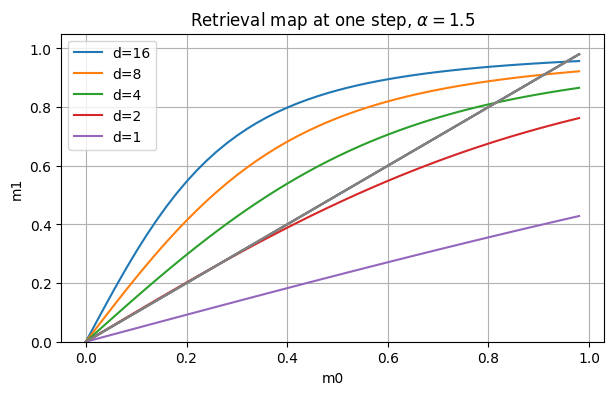

In [ ]:
plt.figure(figsize=(7,4))

for i, d_ in enumerate(d_arr):
    plt.plot(m0_array, m1_results[i], label=f"d={d_}")
    plt.plot(m0_array, m0_array, color="grey")

plt.ylim((0,1.05))
plt.xlabel("m0")
plt.ylabel("m1")
plt.title(r"Retrieval map at one step, $\alpha=${}".format(alpha))
plt.legend()
plt.grid()
plt.show()

In [ ]:
name_save = "retrieval_maps_N250_P750.npy"
basins = np.load(data_PATH+"savings/"+name_save)

N=250
D=0

num_of_run = 20

d_arr = np.array([16,8,4,2,1])

n=1

on_sphere = True

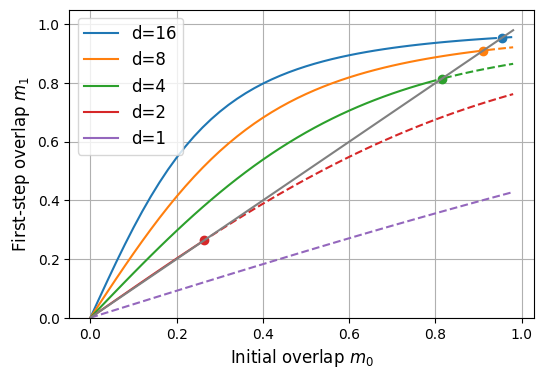

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

colors = ["C0", "C1", "C2", "C3", "C4"]

for i, d_ in enumerate(d_arr):
    # Make the above/below masked arrays
    m1 = m1_results[i]
    above = np.ma.masked_where(m1 <= m0_array, m1)
    below = np.ma.masked_where(m1 >  m0_array, m1)

    color = f"C{i}"  # Use a different color for each d
    plt.plot(m0_array, above, ls='-', label=f"d={d_}", color=colors[i])
    plt.plot(m0_array, below, color=color, ls='--')
    #plt.errorbar(init_overlaps_array, np.mean(basins[i], axis=1)/N, yerr=np.std(basins[i], axis=1)/(N*np.sqrt(num_of_run)), fmt='.', capsize=3, label=r"d={}".format(d_), color=colors[i])


    # --- Find & plot the intersection(s) with the line y = x ---
    diff = m1 - m0_array
    # Indices where diff changes sign => crossing of m1 and m0_array
    sign_changes = np.where(np.diff(np.sign(diff)) != 0)[0]
    for idx in sign_changes:
        # Points to interpolate between
        x0, x1 = m0_array[idx],   m0_array[idx+1]
        y0, y1 = m1[idx],         m1[idx+1]
        # We want x_cross where line from (x0, y0) to (x1, y1) intersects y=x.
        # slope = (y1 - y0) / (x1 - x0); solve y0 + slope*(x - x0) = x
        slope = (y1 - y0) / (x1 - x0)
        x_cross = (slope*x0 - y0) / (slope - 1)
        # y_cross = x_cross on bisector
        plt.plot(x_cross, x_cross, 'o', color=color)

# Bisector
plt.plot(m0_array, m0_array, color="gray")

plt.ylim((0,1.05))
plt.xlabel("Initial overlap $m_0$", fontsize=12)
plt.ylabel("First-step overlap $m_1$", fontsize=12)
#plt.title(r"Retrieval map at one step, $\alpha=${}".format(alpha))
plt.legend(fontsize=12)
plt.grid()
plt.show()


In [14]:

d = 16
alpha_values_16 = np.arange(0.1, 15.5, 0.2)
m0_star_values_16 = find_fixed_points_for_alphas(d, alpha_values_16)
d = 8
alpha_values_8 = np.arange(0.1, 7.5, 0.1)
m0_star_values_8 = find_fixed_points_for_alphas(d, alpha_values_8)
d = 4
alpha_values_4 = np.arange(0.2, 3.53, 0.01)
m0_star_values_4 = find_fixed_points_for_alphas(d, alpha_values_4)
d = 2
alpha_values_2 = np.arange(0.1, 1.58, 0.01)
m0_star_values_2 = find_fixed_points_for_alphas(d, alpha_values_2)

d = 1
alpha_values_1 = np.arange(0.1, 0.3182, 0.0001)
m0_star_values_1 = find_fixed_points_for_alphas(d, alpha_values_1)

/tmp/ipython-input-2140813937.py:17: RuntimeWarning: invalid value encountered in scalar multiply
  return prefactor * np.exp(exponent) * K_d(d, arg) * g_d(d, arg)
/tmp/ipython-input-3461893441.py:22: RuntimeWarning: invalid value encountered in scalar divide
  return iv(0.5*d, x) / iv(0.5*d - 1, x)
/tmp/ipython-input-3461893441.py:12: RuntimeWarning: overflow encountered in scalar multiply
  return factor * iv(0.5*d - 1, x) / (x**(0.5*d - 1))
/tmp/ipython-input-2140813937.py:27: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, _ = quad(integrand, 0, sup)


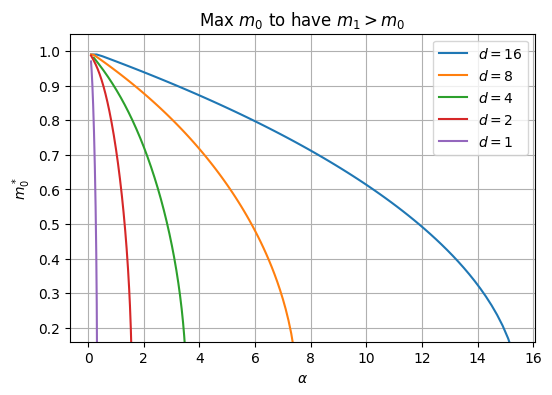

In [16]:
plt.figure(figsize=(6,4))

plt.plot(alpha_values_16, m0_star_values_16)
plt.plot(alpha_values_8, m0_star_values_8)
plt.plot(alpha_values_4, m0_star_values_4)
plt.plot(alpha_values_2, m0_star_values_2)
plt.plot(alpha_values_1, m0_star_values_1)

plt.title(r"Max $m_0$ to have $m_1 > m_0$")

plt.ylim((0.16,1.05))
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$m_0^*$")
plt.legend([r"$d=16$", r"$d=8$", r"$d=4$", r"$d=2$", r"$d=1$"])
plt.grid()


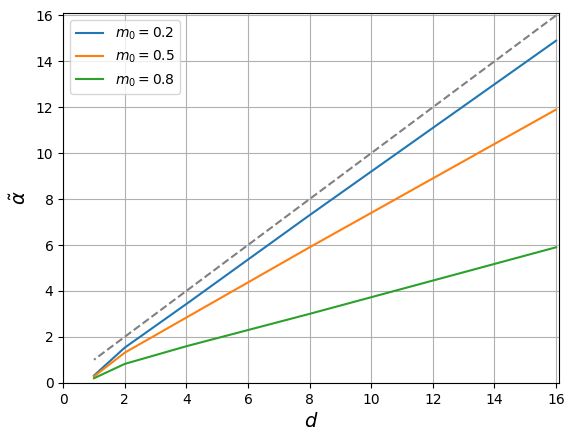

In [17]:
alpha_arr = np.zeros((5))
alpha_arr[0] = alpha_values_16[np.argmin((m0_star_values_16-0.1)**2)]
alpha_arr[1] = alpha_values_8[np.argmin((m0_star_values_8-0.1)**2)]
alpha_arr[2] = alpha_values_4[np.argmin((m0_star_values_4-0.1)**2)]
alpha_arr[3] = alpha_values_2[np.argmin((m0_star_values_2-0.1)**2)]
alpha_arr[4] = alpha_values_1[np.argmin((m0_star_values_1-0.1)**2)]

#plt.plot(d_arr, alpha_arr, "-")

alpha_arr[0] = alpha_values_16[np.argmin((m0_star_values_16-0.2)**2)]
alpha_arr[1] = alpha_values_8[np.argmin((m0_star_values_8-0.2)**2)]
alpha_arr[2] = alpha_values_4[np.argmin((m0_star_values_4-0.2)**2)]
alpha_arr[3] = alpha_values_2[np.argmin((m0_star_values_2-0.2)**2)]
alpha_arr[4] = alpha_values_1[np.argmin((m0_star_values_1-0.2)**2)]

plt.plot(d_arr, alpha_arr, "-")

'''
alpha_arr[0] = alpha_values_16[np.argmin((m0_star_values_16-0.3)**2)]
alpha_arr[1] = alpha_values_8[np.argmin((m0_star_values_8-0.3)**2)]
alpha_arr[2] = alpha_values_4[np.argmin((m0_star_values_4-0.3)**2)]
alpha_arr[3] = alpha_values_2[np.argmin((m0_star_values_2-0.3)**2)]
alpha_arr[4] = alpha_values_1[np.argmin((m0_star_values_1-0.3)**2)]

plt.plot(d_arr, alpha_arr, "-")

alpha_arr[0] = alpha_values_16[np.argmin((m0_star_values_16-0.4)**2)]
alpha_arr[1] = alpha_values_8[np.argmin((m0_star_values_8-0.4)**2)]
alpha_arr[2] = alpha_values_4[np.argmin((m0_star_values_4-0.4)**2)]
alpha_arr[3] = alpha_values_2[np.argmin((m0_star_values_2-0.4)**2)]
alpha_arr[4] = alpha_values_1[np.argmin((m0_star_values_1-0.4)**2)]

plt.plot(d_arr, alpha_arr, "-")
'''

alpha_arr[0] = alpha_values_16[np.argmin((m0_star_values_16-0.5)**2)]
alpha_arr[1] = alpha_values_8[np.argmin((m0_star_values_8-0.5)**2)]
alpha_arr[2] = alpha_values_4[np.argmin((m0_star_values_4-0.5)**2)]
alpha_arr[3] = alpha_values_2[np.argmin((m0_star_values_2-0.5)**2)]
alpha_arr[4] = alpha_values_1[np.argmin((m0_star_values_1-0.5)**2)]

plt.plot(d_arr, alpha_arr, "-")



alpha_arr[0] = alpha_values_16[np.argmin((m0_star_values_16-0.8)**2)]
alpha_arr[1] = alpha_values_8[np.argmin((m0_star_values_8-0.8)**2)]
alpha_arr[2] = alpha_values_4[np.argmin((m0_star_values_4-0.8)**2)]
alpha_arr[3] = alpha_values_2[np.argmin((m0_star_values_2-0.8)**2)]
alpha_arr[4] = alpha_values_1[np.argmin((m0_star_values_1-0.8)**2)]

plt.plot(d_arr, alpha_arr, "-")

plt.legend((r"$m_0=0.2$", r"$m_0=0.5$", r"$m_0=0.8$"))

plt.plot(d_arr, d_arr, "--", color="grey")

plt.xlabel(r"$d$", fontsize=14)
plt.ylabel(r"$\tilde{\alpha}$", fontsize=14)
plt.ylim((0,16.1))
plt.xlim((0., 16.1))
plt.grid()

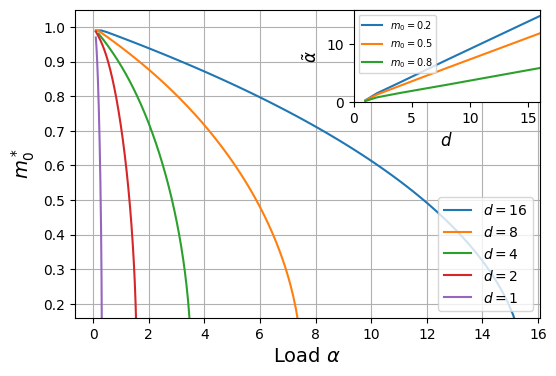

In [20]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Assuming the following arrays are already defined in the workspace:
# alpha_values_16, m0_star_values_16
# alpha_values_8,  m0_star_values_8
# alpha_values_4,  m0_star_values_4
# alpha_values_2,  m0_star_values_2
# alpha_values_1,  m0_star_values_1
# d_arr

fig, ax = plt.subplots(figsize=(6,4))

# Main plot
ax.plot(alpha_values_16, m0_star_values_16)
ax.plot(alpha_values_8,  m0_star_values_8)
ax.plot(alpha_values_4,  m0_star_values_4)
ax.plot(alpha_values_2,  m0_star_values_2)
ax.plot(alpha_values_1,  m0_star_values_1)
#ax.set_title(r"Max $m_0$ to have $m_1 > m_0$")
ax.set_ylim(0.16, 1.05)
ax.set_xlabel(r"Load $\alpha$", fontsize=14)
ax.set_ylabel(r"$m_0^*$", fontsize=14)
ax.legend([r"$d=16$", r"$d=8$", r"$d=4$", r"$d=2$", r"$d=1$"], loc="lower right", fontsize=10)
ax.grid(True)

# Inset axes for the second plot
axins = inset_axes(ax, width="40%", height="30%", loc='upper right', borderpad=0)

# Plotting alpha vs. d for fixed m0 levels 0.2, 0.5, 0.8
levels = [0.2, 0.5, 0.8]
for level in levels:
    alpha_arr = []
    m0_data = [
        (alpha_values_16, m0_star_values_16),
        (alpha_values_8,  m0_star_values_8),
        (alpha_values_4,  m0_star_values_4),
        (alpha_values_2,  m0_star_values_2),
        (alpha_values_1,  m0_star_values_1)
    ]
    for alphas, m0s in m0_data:
        idx = np.argmin((m0s - level)**2)
        alpha_arr.append(alphas[idx])
    axins.plot(d_arr, alpha_arr)

# Diagonal reference line

axins.set_xlim(0, max(d_arr))
axins.set_ylim(0, max(d_arr))
axins.set_xlabel(r"$d$", fontsize=12)
axins.set_ylabel(r"$\tilde{\alpha}$", fontsize=12)
axins.legend([r"$m_0=0.2$", r"$m_0=0.5$", r"$m_0=0.8$"], loc="upper left", fontsize=7)
#axins.grid(True)

plt.show()